# Implementing Quantum Fourier Transform
ECS7011P - Quantum Programming - 2023/24

Author: Chin-Yun Yu

To run this notebook, the following packages are required:

- `qiskit`
- `qiskit-aer`

In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector
from functools import reduce
import math

simulator = AerSimulator()

## Abstract

Quantum Fourier Transform (QFT) is a quantum algorithm that is used to transform a quantum state from the computational basis to the Fourier basis. It is a fundamental algorithm in quantum computing. Moreover, the complexity of QFT is $O((\log_2 N)^2)$, which is much faster than the classical Fourier Transform and can be leveraged in some algorithms to achieve exponential speedup, such as finding the period of a periodic function using Shor's algorithm. In this notebook, we will show how to implement QFT using quantum gates, implement it in Qiskit, and test it with some examples. 

## Introduction

Fourier transform is a powerful transform that can project data from one domain to another. 
The basis of the Fourier transform is the complex exponential function, which are basically cosine and sine functions with different oscillating rates (i.e., frequencies).
Fourier transform compute the amount of projection of data on each frequency, telling us the amount of frequencies present in the data.
It is widely used in signal processing, image processing, and many other fields.

The equivalent of Fourier transform in quantum computing is the Quantum Fourier Transform (QFT).
A significant difference between QFT and classical Fourier transform is that the computational complexity of QFT is significantly less than classical Fourier transform.
This enlights the potential of quantum computing to achieve exponential speedup in some algorithms.

In this notebook, we are going to implement the QFT algorithm using Qiskit.
We will first briefly go through the classical Fourier transform, then introduce the QFT algorithm, and finally implement it in Qiskit and test it on a simple 3-bit example.

The answers to coursework questions:
1. _How does the classical and quantum Fourier analysis compare?_ is briefly discussed in [this section](#the-quantum-fourier-transform).
2. _Encode the binary string 110_: See [this section](#task-2-encoding-the-string-110).
3. _Reconstruct the binary string 110_: See [this section](#task-3-inverse-qft).

$\renewcommand{\ket}[1]{{|#1\rangle}}$

## The Classical Discrete Fourier Transform

In the classical discrete Fourier transform (DFT), given a vector of complex numbers $x[t], 0 \leq t < N$ and $N = 2^n$, the Fourier transform is defined as

$
\begin{align}
X[k] = \sum_{t=0}^{N-1} x[t] e^{-2\pi i \frac{kt}{N}} ,
\end{align}
$

where $X[k]$ is the Fourier transform of $x[t]$. In digital signal processing, $t$ is often interpreted as time, and $k$ is the frequency. $X[k]$ is the projection of the signal $x[t]$ onto the frequency $k$ (more precisely, the angular frequency $2\pi k/N$).

We can represent the DFT as a matrix-vector multiplication:

$
\begin{align}
\begin{vmatrix}
X[0] \\ X[1] \\ \vdots \\ X[N-1]
\end{vmatrix} &= \begin{vmatrix}
1 & 1 & 1 & \cdots & 1 \\
1 & \omega & \omega^2 & \cdots & \omega^{N-1} \\
1 & \omega^2 & \omega^4 & \cdots & \omega^{2(N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \omega^{N-1} & \omega^{2(N-1)} & \cdots & \omega^{(N-1)(N-1)}
\end{vmatrix} \begin{vmatrix}
x[0] \\ x[1] \\ \vdots \\ x[N-1]
\end{vmatrix},
\end{align}
$

where $\omega = e^{-2\pi i/N}$.
It is easy to see that the inverse matrix has the same form but with $\omega = e^{2\pi i/N}$ and a scaling factor of $1/N$.

The naive implementation of (inverse) DFT has a time complexity of $O(N^2) = O(2^{2n})$.
Efficient algorithms such as the Fast Fourier Transform (FFT) can reduce the time complexity to $O(N \log_2 N) = O(n2^n)$.

## The Quantum Fourier Transform

The quantum Fourier transform (QFT) has a similar structure to the classical Fourier transform.
The QFT is defined as

$
\begin{align}
\text{QFT} \ket{x} &= \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \omega^{xy} \ket{y} \\
&= \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2\pi i x\frac{y}{N}} \ket{y},
\end{align}
$

where $\omega = e^{2\pi i / N}$.
It does similar things as the classical Fourier transform, mapping state $\ket{x}$ to a different coordinate system form by $\omega$. It looks almost the same as the classical Fourier transform, besides the input and output are quantum states, and there's a normalisation factor $1/\sqrt{N}$ to maintain unitary (in the classical Fourier transform, the normalisation is done in the inverse DFT by $1/N$).
Also, $\omega = e^{-2\pi i / N}$ is used in DFT, but the choice of sign does not matter in the QFT as they both form orthogonal basis.


### Implementing the QFT

To see how the QFT can be done by quantum gates, let's decompose the QFT like the following:

$
\begin{align}
\text{QFT} \ket{x} &= \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2\pi i x\frac{y}{N}} \ket{y} \\
&= \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^{n} e^{2\pi i x\frac{ y_k}{2^k}} \ket{y_1 y_2 \ldots y_n} \\
&= \frac{1}{\sqrt{N}} \sum_{y_1=0}^{1} \sum_{y_2=0}^{1} \ldots \sum_{y_n=0}^{1} e^{2\pi i x\frac{ y_1}{2^1}} e^{2\pi i x\frac{ y_2}{2^2}} \ldots e^{2\pi i x\frac{ y_n}{2^n}} \ket{y_1 y_2 \ldots y_n} \\
&= \frac{1}{\sqrt{N}} \sum_{y_1=0}^{1} e^{2\pi i x\frac{ y_1}{2^1}} \ket{y_1} \sum_{y_2=0}^{1} e^{2\pi i x\frac{ y_2}{2^2}} \ket{y_2} \ldots \sum_{y_n=0}^{1} e^{2\pi i x\frac{ y_n}{2^n}} \ket{y_n} \\
&= \frac{1}{\sqrt{N}} \left( \ket{0} + e^{2\pi i \frac{x}{2^1}} \ket{1} \right) \otimes \left( \ket{0} + e^{2\pi i \frac{x}{2^2}} \ket{1} \right) \otimes \ldots \otimes \left( \ket{0} + e^{2\pi i \frac{x}{2^n}} \ket{1} \right).
\end{align}
$

Noting that we use the binary expression of $\ket{y} = \ket{y_1 y_2 \ldots y_n}$ and the fact that $y = \sum_{k=1}^{n} y_k 2^{n-k}$.
Intuitively, we can think what QFT does is mapping each qubit to a plane that is orthogonal to $\ket{0}$ and $\ket{1}$, and each bit is rotated with a different frequency $2\pi/2^k$.
The phase positions form a unique set that has a **one-to-one** correspondence with the binary representation of $x$.

The operation, $\frac{1}{\sqrt{2}} \left( \ket{0} + e^{2\pi i \frac{x}{2^k}} \ket{1} \right)$, consists of a phase rotation controlled by $x$.
To realise a controlled-phase gate, let's use the fact that $x = \sum_{k=1}^{n} x_k 2^{n-k}$ so

$
\begin{align}
e^{2\pi i \frac{x}{2^k}} &= e^{2\pi i \sum_{j=1}^{n} x_j \frac{2^{n-j}}{2^k}} \\
&= \prod_{j=n-k+1}^{n} e^{2\pi i x_j 2^{n-j-k}}.
\end{align}
$

We use $j=n-k+1$ as any $x_j$ with $j < n-k+1$ will not affect the phase rotation of the $k$-th qubit.
In other words, we can rewrite the QFT as

$
\begin{align}
\text{QFT} \ket{x} &= \frac{1}{\sqrt{N}} \left( \ket{0} + e^{2\pi i \frac{x}{2^1}} \ket{1} \right) \otimes \left( \ket{0} + e^{2\pi i \frac{x}{2^2}} \ket{1} \right) \otimes \ldots \otimes \left( \ket{0} + e^{2\pi i \frac{x}{2^n}} \ket{1} \right) \\
&= \frac{1}{\sqrt{N}} \left( \ket{0} + e^{2\pi i \frac{x_n}{2}} \ket{1} \right) \otimes \left( \ket{0} + e^{2\pi i \left( \frac{x_{n-1}}{2} + \frac{x_n}{2^2} \right)} \ket{1} \right) \otimes \ldots \otimes \left( \ket{0} + e^{2\pi i \left( \frac{x_1}{2} + \frac{x_2}{2^2} + \ldots + \frac{x_n}{2^n} \right)} \ket{1} \right).
\end{align}
$

Obviously, there is a pattern in the QFT: the $k$-th qubit is controlled by the last $k$ qubits.
The phase rotation can be done by applying $k$ controlled-phase gates using the form

$
\begin{align}
\begin{vmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & e^{i\theta}
\end{vmatrix},
\end{align}
$

where $\theta$ is the phase rotation angle.


### Practical Implementation

To make the computation **feasible** (i.e. the computational order of the gates is an direct acyclic graph), the QFT should be done in reverse order like the following:

$
\begin{align}
\cdots = \frac{1}{\sqrt{N}} \left( \ket{0} + e^{2\pi i \left( \frac{x_1}{2} + \frac{x_2}{2^2} + \ldots + \frac{x_n}{2^n} \right)} \ket{1} \right) \otimes \ldots \otimes \left( \ket{0} + e^{2\pi i \left( \frac{x_{n-1}}{2} + \frac{x_n}{2^2} \right)} \ket{1} \right) \otimes \left( \ket{0} + e^{2\pi i \frac{x_n}{2}} \ket{1} \right),
\end{align}
$

and then we swap the qubits to get the correct order.
In summary, the feasible computation order is done by the following steps:

1. Starting at the most significant qubit $k=1$.
2. Apply the Hadamard gate $H$ to the $k$-th qubit to get $\frac{1}{\sqrt{2}} \left( \ket{0} + e^{\pi i x_k} \ket{1} \right)$.
3. Apply $n-k$ controlled-phase gates controlled by qubits that are less significant than the $k$-th qubit to get the correct phase rotation $\frac{1}{\sqrt{2}} \left( \ket{0} + e^{\pi i \left(x_k + \frac{x_{k+1}}{2} + \ldots + \frac{x_n}{2^{n-k}} \right)} \ket{1} \right)$.
4. Move to the next qubit $k+1$ and repeat the steps until the least significant qubit $k=n$.
5. Swap the qubits to get the correct order.


### The Complexity of QFT

We see that $k$-th qubit is controlled by $k$ gates (one Hadamard gate and $k-1$ controlled-phase gates).
The total number of operations is then $\frac{n(n+1)}{2} + \lfloor \frac{n}{2} \rfloor = O(n^2) = O((\log_2 N)^2) << O(N\log_2 N)$ (including the swap gates).

## Results

Let's implement the QFT in Qiskit and test it with a simple example.

In [2]:
def qft_rotations(
    circuit: QuantumCircuit, target_bit: int, forward: bool = True
) -> QuantumCircuit:
    """
    Performs QFT rotations on the target bit of the circuit

    Args:
        circuit: The quantum circuit
        target_bit: The target bit to perform QFT rotations on
        forward: Whether to perform the forward QFT rotations (True) or the inverse QFT rotations (False)

    Returns:
        The quantum circuit with QFT rotations applied to the target bit
    """
    # apply the phase rotation +- pi
    circuit.barrier(label=f"rot-{target_bit}")
    circuit.h(target_bit)
    phase = math.pi if forward else -math.pi
    if target_bit > 0:
        reduce(
            lambda _, qubit: circuit.cp(
                phase / 2 ** (target_bit - qubit), qubit, target_bit
            ),
            # in Qiskit, the most significant bit is on the right, so the control bits are < target_bit
            range(target_bit),
            None,
        )


def get_qft_circuit(num_qubits: int, **kwargs) -> QuantumCircuit:
    """
    Returns a quantum circuit that performs the Quantum Fourier Transform on the given number of qubits

    Args:
        num_qubits: The number of qubits to perform the QFT on

    Returns:
        The quantum circuit that performs the QFT
    """
    circuit = QuantumCircuit(num_qubits)

    # apply QFT rotations to each qubit, starting from the most significant bit
    reduce(
        lambda _, tb: qft_rotations(circuit, tb, **kwargs),
        range(num_qubits - 1, -1, -1),
        None,
    )
    # swap the qubits
    circuit.barrier(label="swap")
    reduce(
        lambda _, i: circuit.swap(i, num_qubits - 1 - i), range(num_qubits // 2), None
    )
    return circuit

Let's construct a 4-qubit QFT circuit and see how it looks like.

In [3]:
qc = get_qft_circuit(4)
qc.draw()

rot-3                                  rot-2                        »
q_0: ───░─────────■────────────────────────────░─────────■────────────────»
        ░         │                            ░         │                »
q_1: ───░─────────┼────────■───────────────────░─────────┼────────■───────»
        ░         │        │                   ░   ┌───┐ │P(π/4)  │P(π/2) »
q_2: ───░─────────┼────────┼────────■──────────░───┤ H ├─■────────■───────»
        ░   ┌───┐ │P(π/8)  │P(π/4)  │P(π/2)    ░   └───┘                  »
q_3: ───░───┤ H ├─■────────■────────■──────────░──────────────────────────»
        ░   └───┘                              ░                          »
«      rot-1                rot-0 ┌───┐ swap       
«q_0: ───░─────────■──────────░───┤ H ├──░────X────
«        ░   ┌───┐ │P(π/2)    ░   └───┘  ░    │    
«q_1: ───░───┤ H ├─■──────────░──────────░────┼──X─
«        ░   └───┘            ░          ░    │  │ 
«q_2: ───░────────────────────░──────────░────┼──X─
«        ░                    ░          ░    │    
«q_3: ───░────────────────────░──────────░────X────
«        ░                    ░          ░

### Task 2: Encoding the String 110

Let's encode the state 110 (equals to 6 in decimal) using the QFT.

In [4]:
def get_string_as_circuit(state: str, num_qubits: int) -> QuantumCircuit:
    """
    Returns a quantum circuit that prepares the given state

    Args:
        state: The state to prepare
        num_qubits: The number of qubits to prepare the state on

    Returns:
        The quantum circuit that prepares the state
    """
    circuit = QuantumCircuit(num_qubits)
    reduce(
        lambda _, x: circuit.x(x[0]) if x[1] else None,
        enumerate(map(int, reversed(state))),
        None,
    )
    return circuit

Firstly, let's see the state vector of 110 in the computational basis.

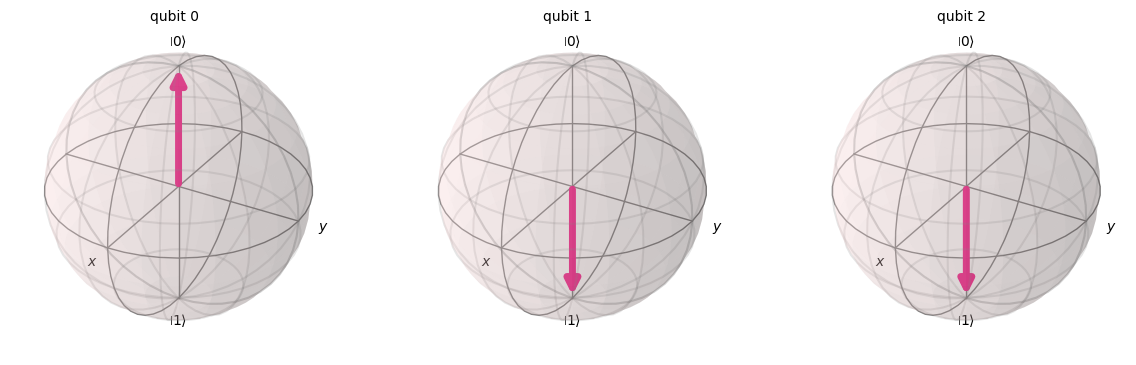

In [5]:
test_data = "110"
data_qc = get_string_as_circuit(test_data, len(test_data))

data_copy = data_qc.copy()
data_copy.save_statevector()
statevector = simulator.run(data_copy).result().get_statevector()
plot_bloch_multivector(statevector)

Before we apply QFT, let's first manually calculate it and then compare the result with the Qiskit implementation.

Using the above formula with $x=6$, we have

$
\begin{align}
y_1 &= \frac{1}{\sqrt{2}} \left( \ket{0} + e^{2\pi i \frac{0}{2}} \ket{1} \right) = \frac{1}{\sqrt{2}} \left( \ket{0} + \ket{1} \right) \\
y_2 &= \frac{1}{\sqrt{2}} \left( \ket{0} + e^{2\pi i \left( \frac{1}{2} + \frac{0}{2^2} \right)} \ket{1} \right) = \frac{1}{\sqrt{2}} \left( \ket{0} + e^{\pi i} \ket{1} \right) \\
y_3 &= \frac{1}{\sqrt{2}} \left( \ket{0} + e^{2\pi i \left( \frac{1}{2} + \frac{1}{2^2} + \frac{0}{2^3} \right)} \ket{1} \right) = \frac{1}{\sqrt{2}} \left( \ket{0} + e^{\frac{3}{2} \pi i} \ket{1} \right) \\
\end{align}
$

Let's see if the Qiskit implementation gives the same result.

In [6]:
task2_qc = data_qc.compose(get_qft_circuit(len(test_data)))
task2_qc.draw()

rot-2                         rot-1                rot-0 ┌───┐ swap »
q_0: ────────░─────────■───────────────────░─────────■──────────░───┤ H ├──░───»
     ┌───┐   ░         │                   ░   ┌───┐ │P(π/2)    ░   └───┘  ░   »
q_1: ┤ X ├───░─────────┼────────■──────────░───┤ H ├─■──────────░──────────░───»
     ├───┤   ░   ┌───┐ │P(π/4)  │P(π/2)    ░   └───┘            ░          ░   »
q_2: ┤ X ├───░───┤ H ├─■────────■──────────░────────────────────░──────────░───»
     └───┘   ░   └───┘                     ░                    ░          ░   »
«        
«q_0: ─X─
«      │ 
«q_1: ─┼─
«      │ 
«q_2: ─X─
«

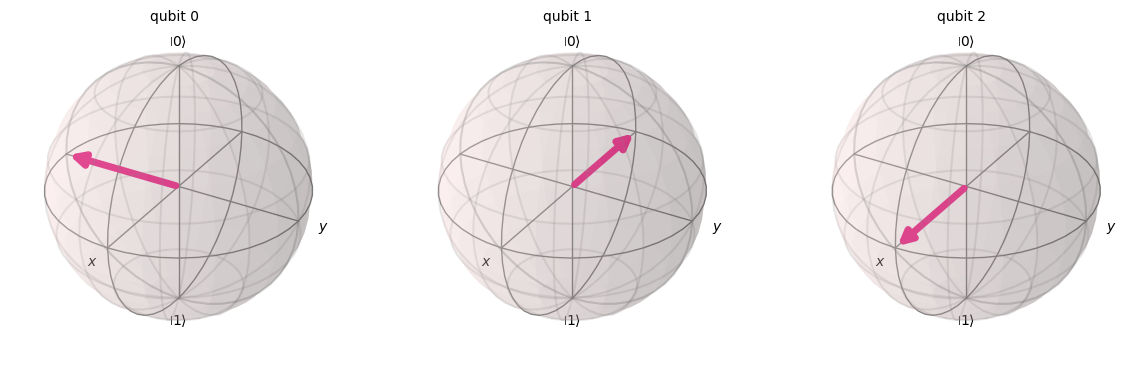

In [7]:
task2_copy = task2_qc.copy()
task2_copy.save_statevector()
statevector = simulator.run(task2_copy).result().get_statevector()
plot_bloch_multivector(statevector)

The block sphere representation verifies our calculation.
The first qubit (right) lies on the xy-plane with zero rotation (a.k.a $\ket{+}$); the second qubit (middle) rotate $\pi$ around the z-axis; the third qubit (left) rotate $3\pi/2$ counterclockwise around the z-axis.

### Task 3: Inverse QFT

Similar to DFT, the inverse QFT can be calculated by rotating the phase in the opposite direction.
Let's implement the inverse QFT and see if we can recover the original state.

In [8]:
inverse_qc = get_qft_circuit(len(test_data), forward=False)
inverse_qc.draw()

rot-2                           rot-1                 rot-0 ┌───┐ swap »
q_0: ───░─────────■─────────────────────░─────────■───────────░───┤ H ├──░───»
        ░         │                     ░   ┌───┐ │P(-π/2)    ░   └───┘  ░   »
q_1: ───░─────────┼─────────■───────────░───┤ H ├─■───────────░──────────░───»
        ░   ┌───┐ │P(-π/4)  │P(-π/2)    ░   └───┘             ░          ░   »
q_2: ───░───┤ H ├─■─────────■───────────░─────────────────────░──────────░───»
        ░   └───┘                       ░                     ░          ░   »
«        
«q_0: ─X─
«      │ 
«q_1: ─┼─
«      │ 
«q_2: ─X─
«

Alternative, we can also just reverse all the gates of QFT.

In [9]:
inverse_qc2 = get_qft_circuit(len(test_data), forward=True).inverse()
inverse_qc2.draw()

░ ┌───┐ ░                 ░                           ░ 
q_0: ─X──░─┤ H ├─░──■──────────────░────────────■──────────────░─
      │  ░ └───┘ ░  │P(-π/2) ┌───┐ ░            │              ░ 
q_1: ─┼──░───────░──■────────┤ H ├─░──■─────────┼──────────────░─
      │  ░       ░           └───┘ ░  │P(-π/2)  │P(-π/4) ┌───┐ ░ 
q_2: ─X──░───────░─────────────────░──■─────────■────────┤ H ├─░─
         ░       ░                 ░                     └───┘ ░

That's construct a circuit that represent the phase of 110 after QFT.

In [10]:
qc = QuantumCircuit(3)
for qubit in range(3):
    qc.h(qubit)
qc.p(3 * math.pi / 2, 0)
qc.p(math.pi, 1)
# qc.p(6 * math.pi, 2)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(3π/2) ├
     ├───┤└─┬──────┬┘
q_1: ┤ H ├──┤ P(π) ├─
     ├───┤  └──────┘ 
q_2: ┤ H ├───────────
     └───┘

Let's apply the inverse QFT to the state and see if we can recover the original state.

In [11]:
task3_qc = qc.compose(inverse_qc)
task3_qc.draw()

┌───┐┌─────────┐ rot-2                           rot-1                »
q_0: ┤ H ├┤ P(3π/2) ├───░─────────■─────────────────────░─────────■────────»
     ├───┤└─┬──────┬┘   ░         │                     ░   ┌───┐ │P(-π/2) »
q_1: ┤ H ├──┤ P(π) ├────░─────────┼─────────■───────────░───┤ H ├─■────────»
     ├───┤  └──────┘    ░   ┌───┐ │P(-π/4)  │P(-π/2)    ░   └───┘          »
q_2: ┤ H ├──────────────░───┤ H ├─■─────────■───────────░──────────────────»
     └───┘              ░   └───┘                       ░                  »
«      rot-0 ┌───┐ swap    
«q_0: ───░───┤ H ├──░────X─
«        ░   └───┘  ░    │ 
«q_1: ───░──────────░────┼─
«        ░          ░    │ 
«q_2: ───░──────────░────X─
«        ░          ░

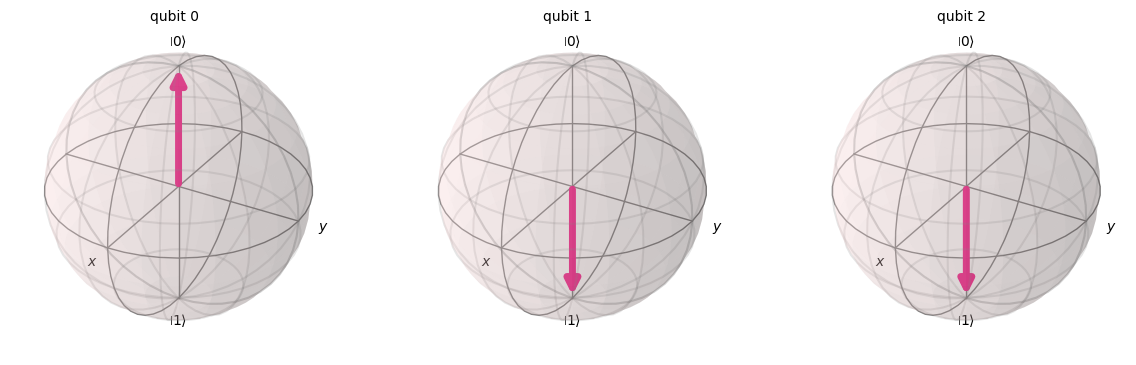

In [12]:
task3_copy = task3_qc.copy()
task3_copy.save_statevector()
statevector = simulator.run(task3_copy).result().get_statevector()
plot_bloch_multivector(statevector)

In [13]:
task3_qc2 = qc.compose(inverse_qc2)
task3_qc2.draw()

┌───┐┌─────────┐    ░ ┌───┐ ░                 ░                          »
q_0: ┤ H ├┤ P(3π/2) ├─X──░─┤ H ├─░──■──────────────░────────────■─────────────»
     ├───┤└─┬──────┬┘ │  ░ └───┘ ░  │P(-π/2) ┌───┐ ░            │             »
q_1: ┤ H ├──┤ P(π) ├──┼──░───────░──■────────┤ H ├─░──■─────────┼─────────────»
     ├───┤  └──────┘  │  ░       ░           └───┘ ░  │P(-π/2)  │P(-π/4) ┌───┐»
q_2: ┤ H ├────────────X──░───────░─────────────────░──■─────────■────────┤ H ├»
     └───┘               ░       ░                 ░                     └───┘»
«      ░ 
«q_0: ─░─
«      ░ 
«q_1: ─░─
«      ░ 
«q_2: ─░─
«      ░

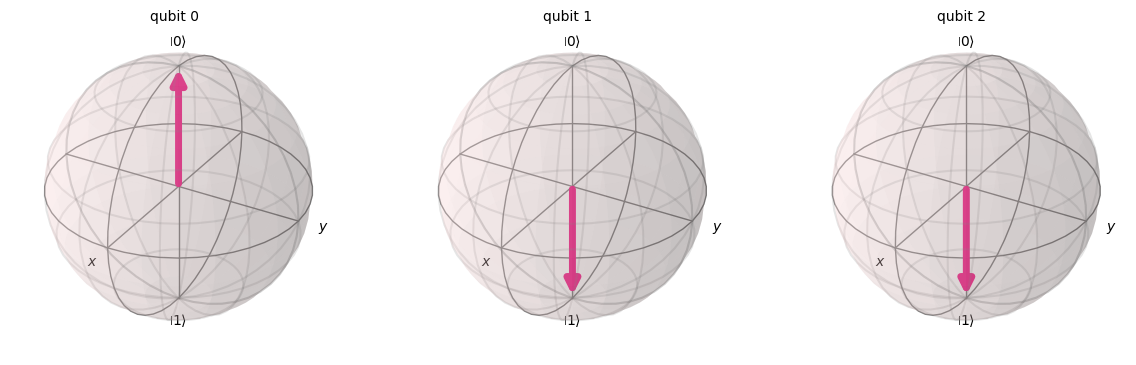

In [14]:
task3_copy = task3_qc2.copy()
task3_copy.save_statevector()
statevector = simulator.run(task3_copy).result().get_statevector()
plot_bloch_multivector(statevector)

We see that not only we succesfully recover the original state (110) but also show that the two version of inverse QFT are equivalent.

## Summary

In this notebook, we have implemented the Quantum Fourier Transform (QFT) and its inverse using Qiskit.
We test it on a simple 3-bit string and show that the QFT can transform the state from the computational basis to the Fourier basis and the inverse QFT can recover the original state.
Moreover, we show two different implementations of inverse QFT and demonstrate that they perform the same operation.

## References

The derivation of the QFT is based on the IBM Qiskit notebook of QFT [1], with some details that are skipped in the original notebook and my own interpretation of the algorithm.

1. [Qiskit: Quantum Fourier Transform](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-fourier-transform.ipynb)